# **ALARAJOY Library Conversion QA Notebook**


This Jupyter Notebook is designed to enable comparisons for neutron activation responses of a given single parent element as calculated by ALARA for the purpose of validating ALARAJOY-processed data from the FENDL3.2x data sets.

**Import Packages**

In [142]:
from pyalara import fill_alara_template, write_alara_input_file, run_alara
import importlib
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../alara_output_processing')
import alara_output_processing as aop
import alara_output_plotting as alaraplot


**Run ALARA with each prepared binary data library**

In [143]:
data_source = {
    'fendl2' : '/groupspace/shared/n/nukecode/ALARA/data/fendl2bin', # Example path
    'fendl3' : '../../examples/data/fendl3' # Example path
}

element = input('Select single parent element to evaluate: ').lower()

for libname, binary in data_source.items():
    alara_input = fill_alara_template(element, binary)
    write_alara_input_file(alara_input)
    output = run_alara(element,libname)
    data_source[libname] = output
data_source

{'fendl2': 'fe_fendl2.out', 'fendl3': 'fe_fendl3.out'}

**Convert ALARA output files to Specialized ALARA DataFrame (ALARADFrame)**

Store all tabular data from both runs' output files into a single ALARADFrame of the form:

```
{
    'time'      : Cooling time of data entry,
    'time_unit' : Units for cooling times,
    'nuclide'   : Individual nuclide,
    'run_lbl'   : Distinguisher between runs,
    'block'     : ALARADFrame block integer enumerator,
    'block_num' : Geometric position of block,
    'variable'  : ALARADFrame variable integer enumerator,
    'var_unit'  : Unit for corresponding variable,
    'value'     : Float value for the corresponding variable
} 
```

In [144]:
importlib.reload(aop)
lib = aop.DataLibrary()
adf = aop.DataLibrary.make_entries(lib, data_source)
adf

,time,time_unit,nuclide,run_lbl,block,block_num,variable,var_unit,value
0,0.000000e+00,s,h-1,fendl2,0,1,0,atoms/kg,1.176100e+22
1,3.153600e+02,s,h-1,fendl2,0,1,0,atoms/kg,1.176100e+22
2,3.153600e+05,s,h-1,fendl2,0,1,0,atoms/kg,1.176100e+22
3,3.153600e+07,s,h-1,fendl2,0,1,0,atoms/kg,1.176100e+22
4,3.153600e+09,s,h-1,fendl2,0,1,0,atoms/kg,1.176100e+22
...,...,...,...,...,...,...,...,...,...
1675,3.153600e+02,s,total,fendl3,0,1,6,Sv/hr,4.619700e+04
1676,3.153600e+05,s,total,fendl3,0,1,6,Sv/hr,3.624700e+03
1677,3.153600e+07,s,total,fendl3,0,1,6,Sv/hr,1.613400e+03
1678,3.153600e+09,s,total,fendl3,0,1,6,Sv/hr,2.942800e-08


**Plot for a single data source**

Simple plot showing the top five contributors to number density from a single data source. The function `alaraplot.plot_single_response()` can be used either singularly or comparitavely between data libraries.

Additionally, stable isotopes of the irradiated target element can be filtered out to produce a clearer picture of the sample's transmutation products.

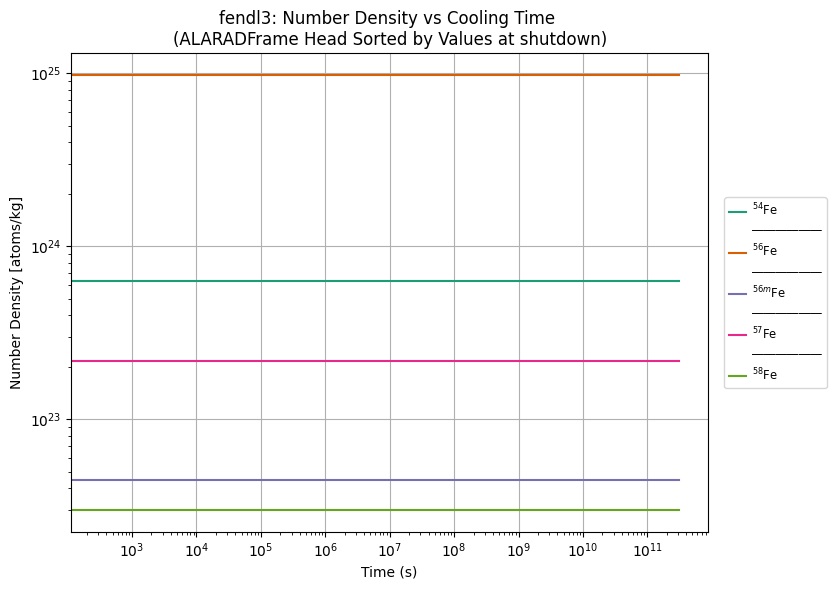

In [145]:
importlib.reload(alaraplot)
f3_numdens_plot = alaraplot.plot_single_response(
    adf,
    run_lbls='fendl3',
    variable='Number Density',
    head=6,
    total=False
)

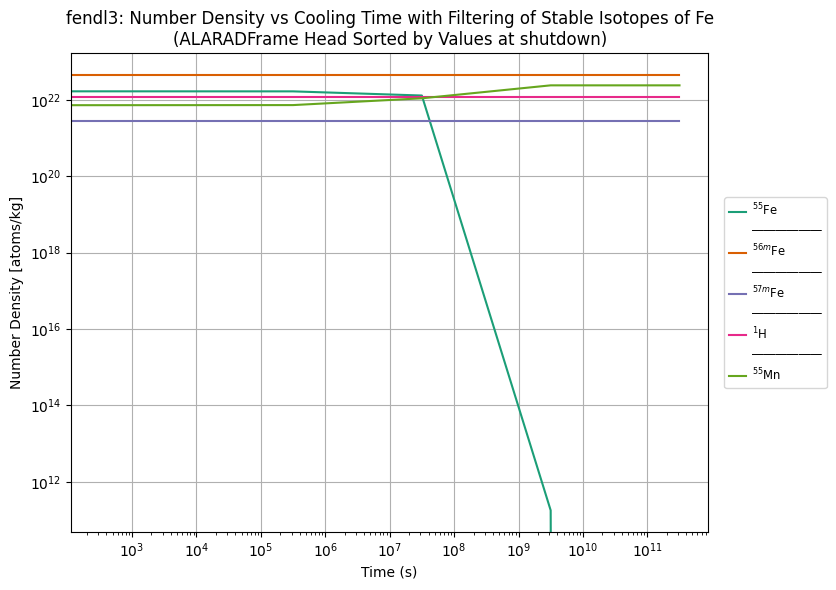

In [146]:
f3_numdens_plot_no_stable_fe = alaraplot.plot_single_response(
    adf,
    run_lbls='fendl3',
    variable='Number Density',
    nuclides=f'!{element}',
    head=6,
    total=False
)

**Comparitavely plot data for FENDL2 and ALARAJOY-processed FENDL3 data**

Below are three example plots showing this comparative functionality. The first follows the above single data source number density plot, here comparing the plots for both data sets.

The second plot employs stable isotope filtering of iron, similarly to the single run example above.

The third plot focuses specifically on the number density of light gas production.

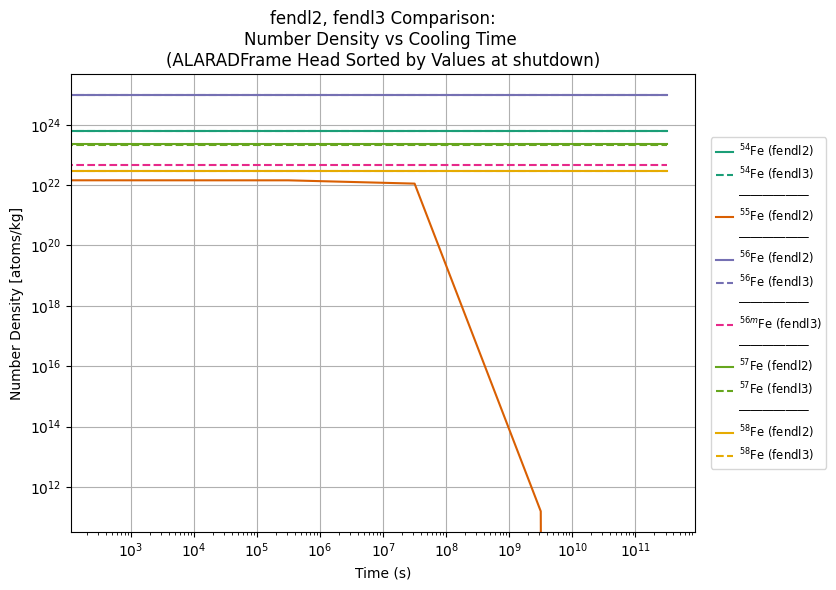

In [147]:
datalibs = ['fendl2', 'fendl3']

comp_numdens_plot = alaraplot.plot_single_response(
    adf,
    run_lbls=datalibs,
    variable='Number Density',
    head=6
)

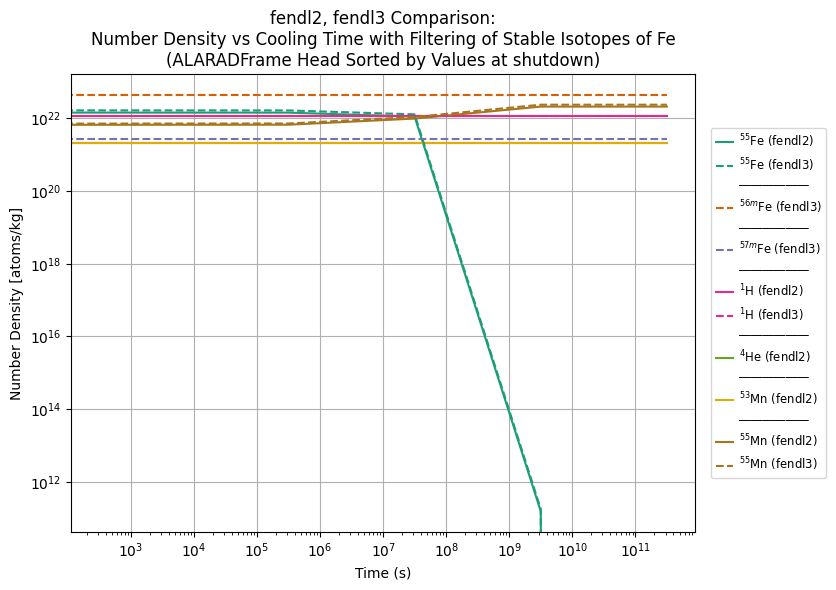

In [148]:
comp_numdens_plot_no_stable_fe = alaraplot.plot_single_response(
    adf,
    run_lbls=datalibs,
    variable='Number Density',
    nuclides=f'!{element}',
    head=6
)

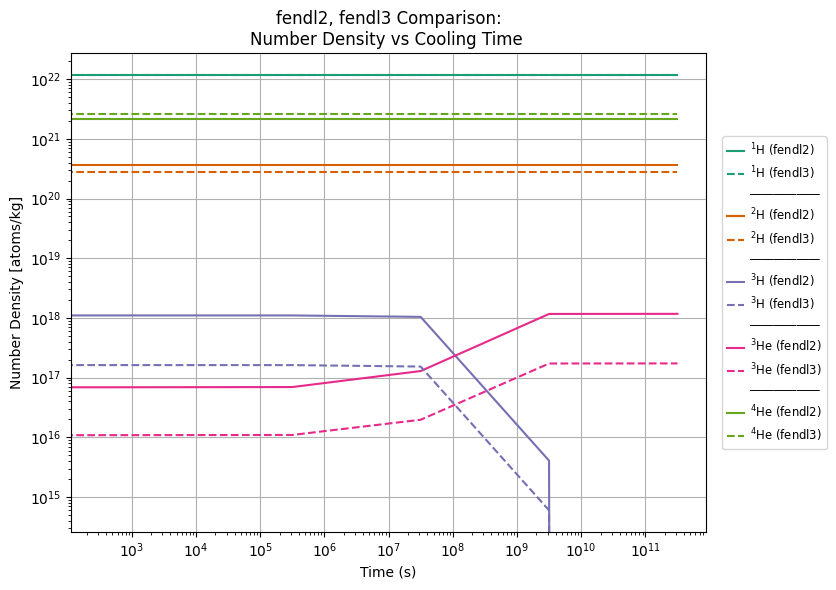

In [149]:
importlib.reload(alaraplot)
gases = ['h', 'he']
comp_gas_plot = alaraplot.plot_single_response(
    adf,
    run_lbls=datalibs,
    variable='Number Density',
    nuclides=gases 
)

**Iteratively compare total values for each variable**

The ALARA simulations initiated by `alarajoy_QA` produce tables tracking four variables against cooling times:

1. Number Density (atoms/kg)
2. Specific Activity (Bq/kg)
3. Total Decay Heat (W/kg)
4. Contact Dose (Sv/hr)

In reality, specific activity, total decay heat, and contact dose are all functions of number density (as well as the particular radiological properties of the produced radionuclides), however, the inclusion of these other variables in certain plotting scenarios can nonetheless prove valuable in studying particular decay patterns, such as identifying discrepancies in particular isotopic contributions to long term activity.

The following example plots show the comparison of the total values for each of these variables respectively at each cooling time across both of the data libraries.

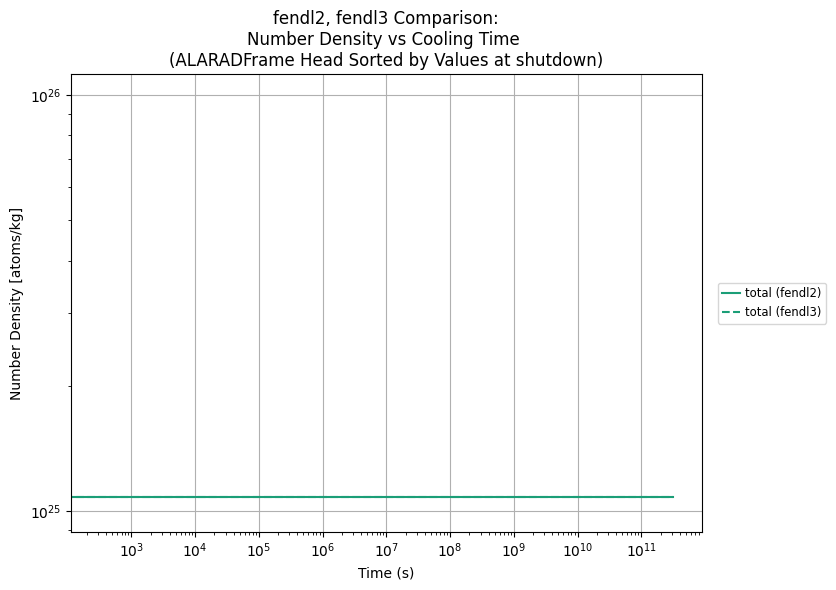

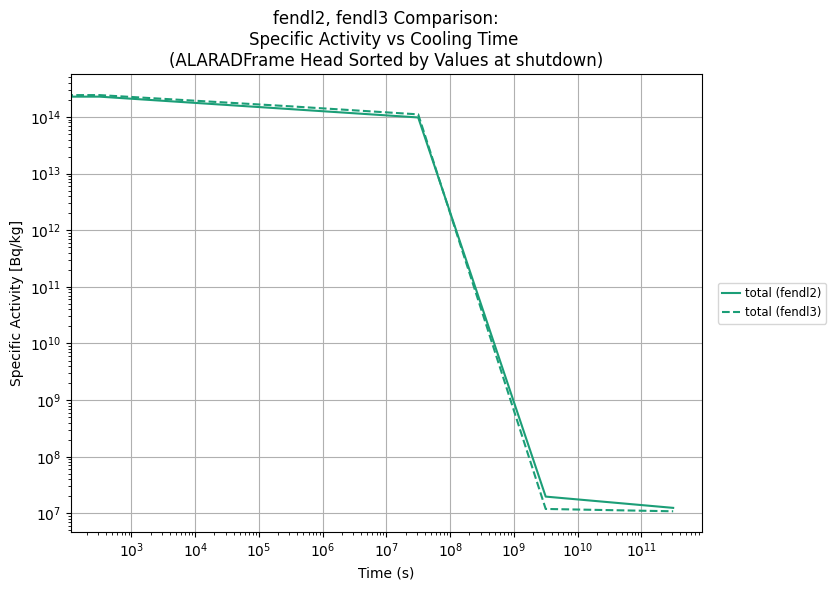

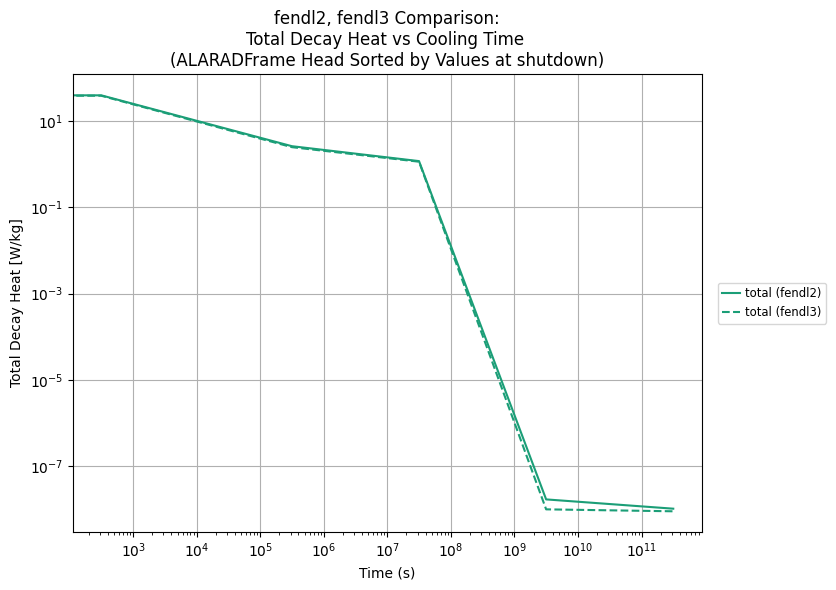

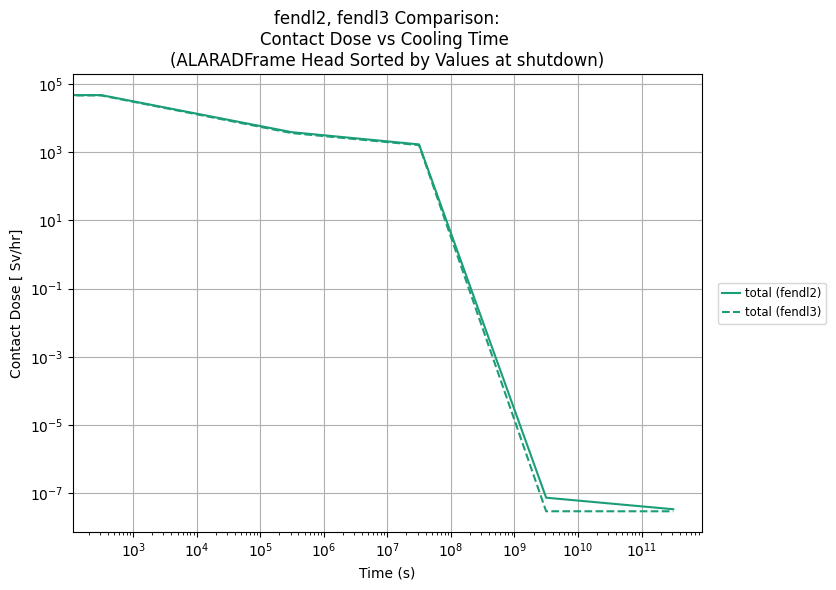

In [150]:
importlib.reload(alaraplot)

variables = [
    'Number Density', 'Specific Activity', 'Total Decay Heat', 'Contact Dose'
]

for variable in variables:
    comp_plot = alaraplot.plot_single_response(
        adf,
        run_lbls=datalibs,
        variable=variable,
        total=True,
        head=1
    )

**Create a pie chart of nuclide contributions at a single time slice**

For a **single run and variable**, the function `alaraplot.single_time_pie_chart()` can be used to plot the relative contributions of all isotopes above a user-defined proportional threshold at a given time.

`alaraplot.single_time_pie_chart()` is also compatable with single element stable isotope filtering, as above.

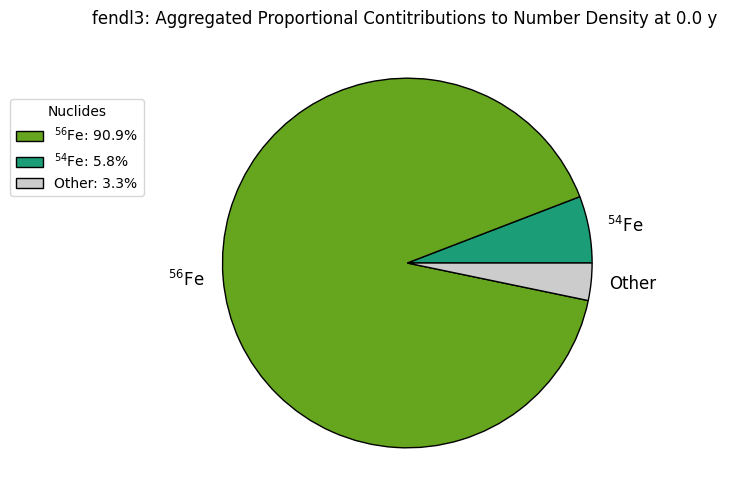

In [151]:
importlib.reload(alaraplot)
agg = alaraplot.pie_chart_aggregation(
    adf=adf,
    run_lbl='fendl3',
    variable='Number Density',
    threshold=0.05,
    time_unit='y'
)
single_pie = alaraplot.single_time_pie_chart(
    agg=agg,
    run_lbl='fendl3',
    variable='Number Density',
    threshold=0.05,
    time_idx=0,
    time_unit='y'
)

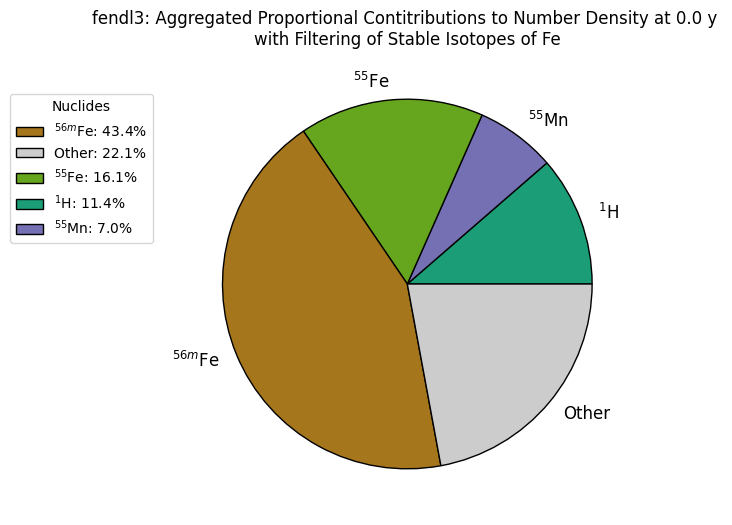

In [152]:
agg_no_stable_fe = alaraplot.pie_chart_aggregation(
    adf=adf.filter_rows({'nuclide' : '!fe'}),
    run_lbl='fendl3',
    variable='Number Density',
    threshold=0.05,
    time_unit='y',
    nuc_filter=True
)
single_pie_no_stable_fe = alaraplot.single_time_pie_chart(
    agg=agg_no_stable_fe,
    run_lbl='fendl3',
    variable='Number Density',
    threshold=0.05,
    time_idx=0,
    time_unit='y',
    stable_filter=element
)

**Create a grid of pie charts for each cooling time for a single run's response**

The example below shows the expansion of the pie chart plotting functionality for a single run and response across all of its cooling times, to illustrate changes in relative contributions of specific nuclides at different times.

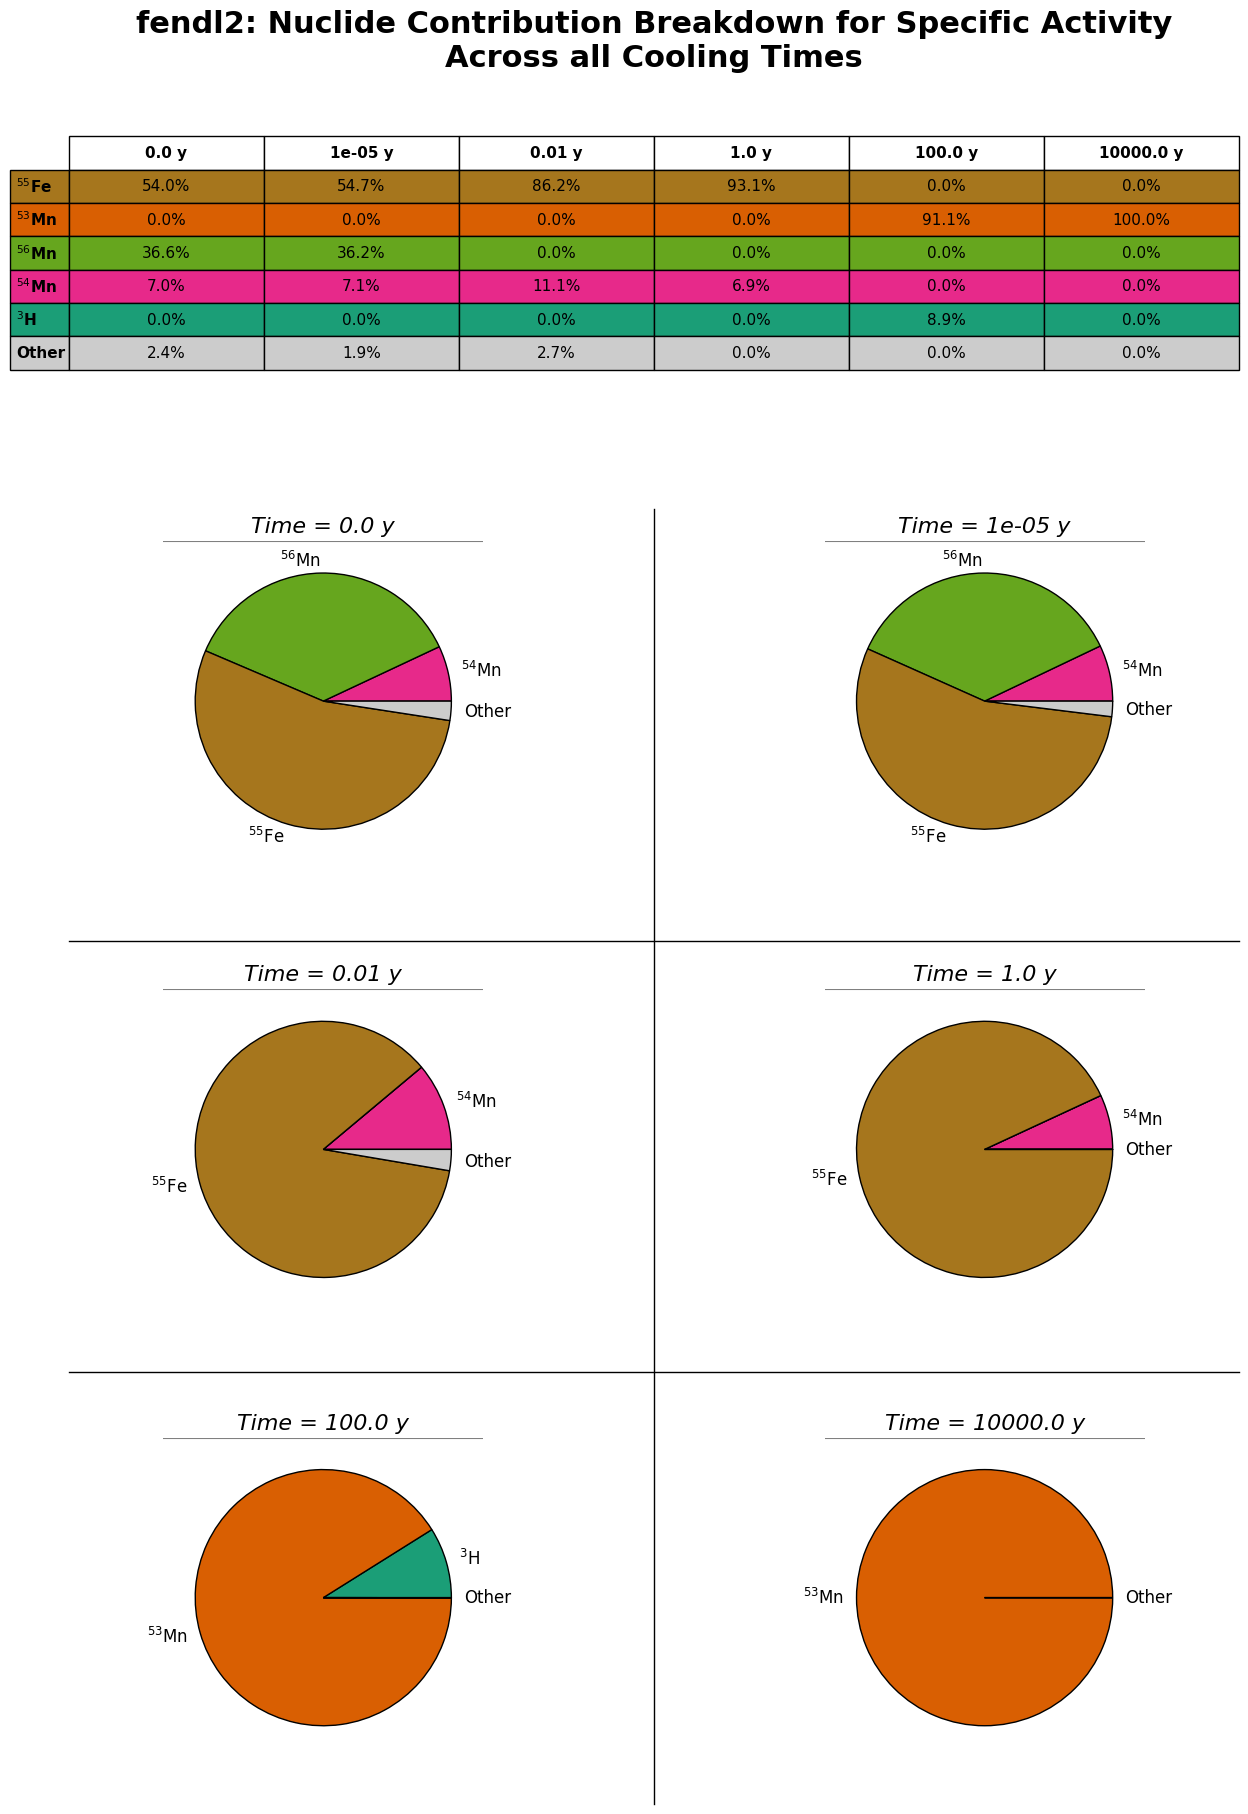

In [153]:
importlib.reload(alaraplot)

agg = alaraplot.pie_chart_aggregation(
    adf=adf,
    run_lbl='fendl3',
    variable='Specific Activity',
    threshold=0.05,
    time_unit='y'
)

multi_pie = alaraplot.multi_time_pie_grid(
    agg=agg,
    run_lbl='fendl2',
    variable='Specific Activity',
    threshold=0.05,
    time_unit='y',
    ncols=2
)

**Extending individual pie chart data over time**

The plots below extend each time slice frtom the above pie charts to show the relative contributions of each variable over time.

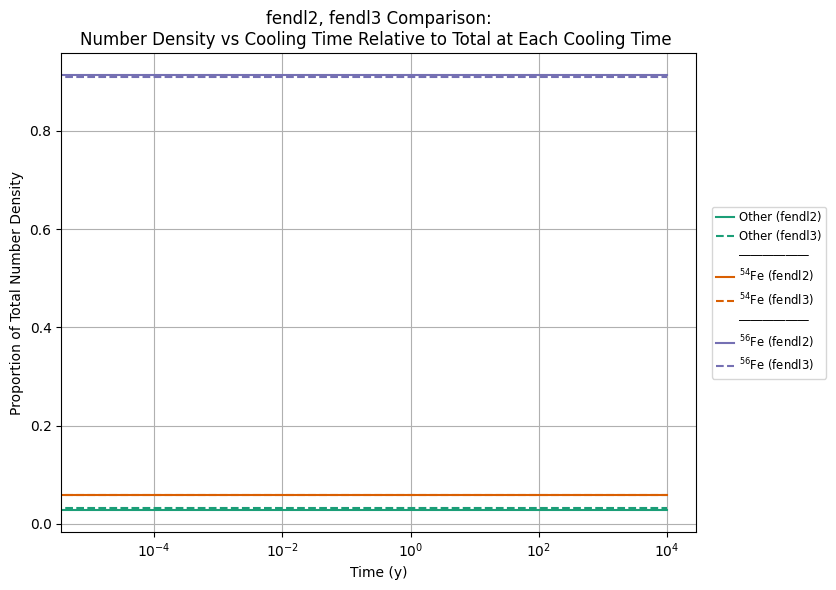

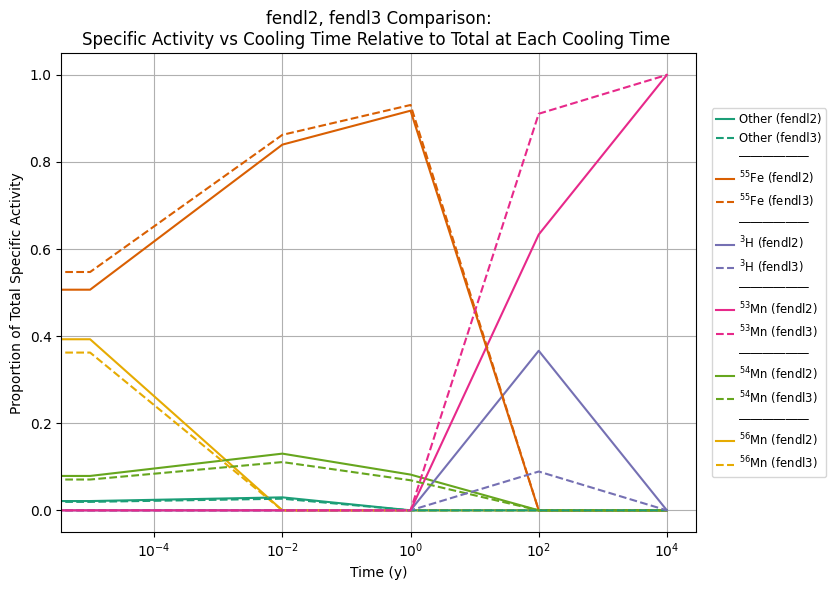

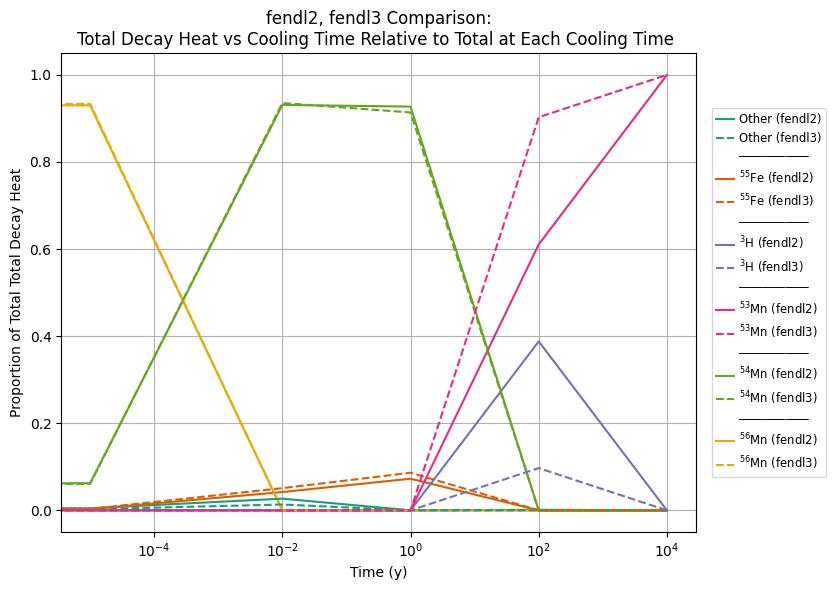

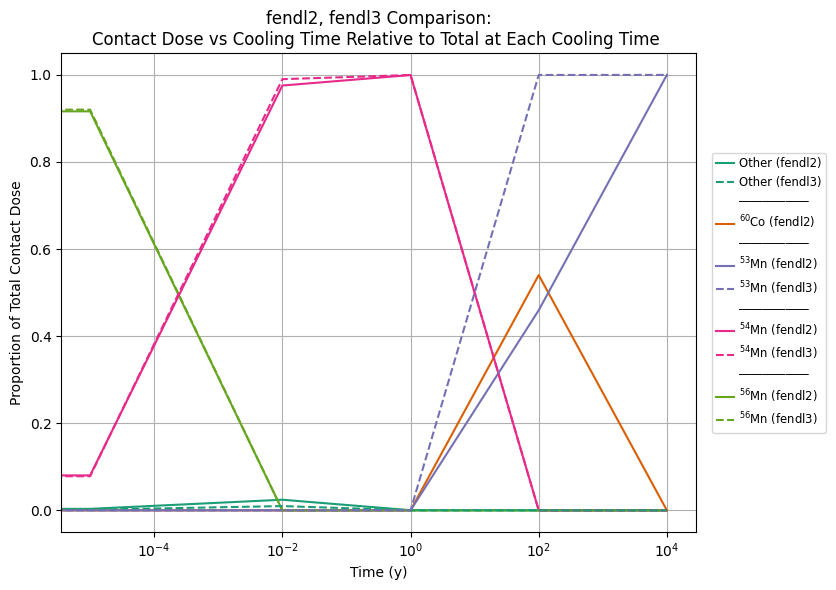

In [154]:
variables = [
    'Number Density', 'Specific Activity', 'Total Decay Heat', 'Contact Dose'
    ]
runs = ['fendl2', 'fendl3']
for variable in variables:
    aggs = []
    for run in runs:
        agg = alaraplot.pie_chart_aggregation(
            adf=adf,
            run_lbl=run,
            variable=variable,
            time_unit='y',
            threshold=0.05
        )
        aggs.append(agg)

    comp_plot = alaraplot.plot_single_response(
        adf=pd.concat(aggs),
        run_lbls=runs,
        variable=variable,
        time_unit='y',
        relative=True
    )